## Problem: Detection of aggressive tweets

Training dataset has 12800 tweets (in english) and validation dataset has 3200 tweets.<br/>
Tweets are labeled (by human) as:
* 1 (Cyber-Aggressive; 9714 items)
* 0 (Non Cyber-Aggressive; 6286 items)

# Classification of Tweets

## Data

In [1]:
import pandas as pd
import numpy as np

In [2]:
data_train = pd.read_json('./Data/train.json')
data_valid = pd.read_json('./Data/valid.json')

In [3]:
X_train = data_train.content
y_train = data_train.label
X_test = data_valid.content
y_test = data_valid.label

## Preprocessing

In [4]:
import nltk
import re

from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from mytextpreprocessing import TextPreprocessor
from mytextpreprocessing import FrequencyExtractor
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MaxAbsScaler
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve

from myutils import *

In [5]:
# nltk.download()

In [6]:
def print_accuracy(pipe, X):
    pipe.fit(X, y_train);

    y_train_pred = pipe.predict(X)
    y_test_pred = pipe.predict(X_test)

    print('Tarining dataset: accuracy = %.3f' % accuracy_score(y_pred=y_train_pred, y_true=y_train))
    print('Test dataset: accuracy = %.3f' % accuracy_score(y_pred=y_test_pred, y_true=y_test))

Additional features give some infromation (the accuracy is higher than 0.607)

In [7]:
print('Train: {:.4f}'.format(1 - y_train.mean()))
print('Test: {:.4f}'.format(1 - y_test.mean()))

Train: 0.6070
Test: 0.6075


In [8]:
test_pipe = Pipeline([('feats', FrequencyExtractor()),
                      ('clf', LogisticRegression(penalty='l2', C=1.0))
                     ])

print_accuracy(test_pipe, X_train)

Tarining dataset: accuracy = 0.615
Test dataset: accuracy = 0.617


Text normalization seems to be irrelevant for the results

In [9]:
token_pattern = '(?u)\\b[a-z\'*]{2,}\\b'

In [10]:
test_pipe = Pipeline([('vectorizer', CountVectorizer(token_pattern=token_pattern)),
                      ('scaler', MaxAbsScaler()),
                      ('clf', LogisticRegression(penalty='l2', C=1.0))])

print_accuracy(test_pipe, X_train)
print('============================================')
X_train_normalized = TextPreprocessor().normalize(X_train)
print_accuracy(test_pipe, X_train_normalized)

Tarining dataset: accuracy = 0.919
Test dataset: accuracy = 0.807
Tarining dataset: accuracy = 0.919
Test dataset: accuracy = 0.806


In [11]:
test_pipe = Pipeline([('vectorizer', CountVectorizer(token_pattern=token_pattern, ngram_range=(1, 2))),
                      ('scaler', MaxAbsScaler()),
                      ('clf', LogisticRegression(penalty='l2', C=1.0))])

print_accuracy(test_pipe, X_train)
print('============================================')
X_train_normalized = TextPreprocessor().normalize(X_train)
print_accuracy(test_pipe, X_train_normalized)

Tarining dataset: accuracy = 0.987
Test dataset: accuracy = 0.887
Tarining dataset: accuracy = 0.992
Test dataset: accuracy = 0.884


Text normalization is useful to reduce number of fetures

In [12]:
STOPWORDS = nltk.corpus.stopwords.words('english')
IRRELEVANT_STOPWORDS = list(pd.read_csv('./Data/irrelevant_stopwords.csv', header=None)[0].values)

In [13]:
dtm = CountVectorizer(token_pattern=token_pattern).fit_transform(X_train)

print('Number of features: %i' % dtm.shape[1])
inds = np.argwhere(dtm.sum(axis=0) == 1)[:, 1]
print('Number of single words: %i' % inds.shape[0])
print('Ratio = %.3f' % (inds.shape[0] / dtm.shape[1],))

Number of features: 13149
Number of single words: 6191
Ratio = 0.471


In [14]:
# check outliers
dtm_array = dtm.toarray()
print('======= max =======')
print((dtm_array.max(axis=0) - dtm_array.min(axis=0)).max())
ind = np.argmax((dtm_array.max(axis=0) - dtm_array.min(axis=0)))
print(dtm_array[:, ind].min(), dtm_array[:, ind].mean(), dtm_array[:, ind].max())
print((dtm_array[:, ind] > 1).sum())
print('======= min =======')
print((dtm_array.max(axis=0) - dtm_array.min(axis=0)).min())
print('======= mean =======')
print((dtm_array.max(axis=0) - dtm_array.min(axis=0)).mean())
print('======= no. of columns with outliers =======')
mu, sigma = np.mean(dtm_array, axis=0), np.std(dtm_array, axis=0)
print((np.abs(dtm_array - mu) > 3 * sigma).any(axis=0).sum())

======= max =======
51
0 0.00734375 51
2
======= min =======
1
======= mean =======
1.10601566659
======= no. of columns with outliers =======
13149


In [15]:
# normalization
test_pipe = Pipeline([('preprocessor', TextPreprocessor(process='', 
                                                        stopwords=[])),
                      ('vectorizer', CountVectorizer(token_pattern=token_pattern))])
dtm = test_pipe.fit_transform(X_train)

print('Number of features: %i' % dtm.shape[1])
inds = np.argwhere(dtm.sum(axis=0) == 1)[:, 1]
print('Number of single words: %i' % inds.shape[0])
print('Ratio = %.3f' % (inds.shape[0] / dtm.shape[1],))

Number of features: 12680
Number of single words: 5867
Ratio = 0.463


In [16]:
# normalization + stemming
test_pipe = Pipeline([('preprocessor', TextPreprocessor(process='stem', 
                                                        stopwords=IRRELEVANT_STOPWORDS)),
                      ('vectorizer', CountVectorizer(token_pattern=token_pattern))])
dtm = test_pipe.fit_transform(X_train)

print('Number of features: %i' % dtm.shape[1])
inds = np.argwhere(dtm.sum(axis=0) == 1)[:, 1]
print('Number of single words: %i' % inds.shape[0])
print('Ratio = %.3f' % (inds.shape[0] / dtm.shape[1],))

Number of features: 9883
Number of single words: 4353
Ratio = 0.440


In [17]:
# normalization + lemmatization
test_pipe = Pipeline([('preprocessor', TextPreprocessor(process='lem', 
                                                        stopwords=IRRELEVANT_STOPWORDS)),
                      ('vectorizer', CountVectorizer(token_pattern=token_pattern))])
dtm = test_pipe.fit_transform(X_train)

print('Number of features: %i' % dtm.shape[1])
inds = np.argwhere(dtm.sum(axis=0) == 1)[:, 1]
print('Number of single words: %i' % inds.shape[0])
print('Ratio = %.3f' % (inds.shape[0] / dtm.shape[1],))

Number of features: 10900
Number of single words: 5114
Ratio = 0.469


In [18]:
np.array(test_pipe.named_steps['vectorizer'].get_feature_names())[inds][:150]

array(["a'capella", 'aa', 'aaron', 'aaronage', 'aawwhh', 'ab', 'abbey',
       'abcdefghijklmnopqrstuvwxyz', 'abducted', 'aboard', 'abouht',
       'abour', 'aboustly', 'aboutt', 'abraham', 'abrams', 'absolute',
       'ac', 'academy', 'acai', 'accomplish', 'accomplishment',
       'accountability', 'accountt', 'accpet', 'accumulate', 'accuracy',
       'acid', 'acknowledgment', 'acne', 'acronym', 'acrylic', 'actaully',
       'activesync', 'activex', 'activist', 'actress', 'actvities',
       'adams', 'adangta', 'adapt', 'adapter', 'addy', 'adedd', 'adfreak',
       'adhd', 'adidas', 'adium', 'admin', 'administration', 'admirer',
       'adolescent', 'adonis', 'adrants', 'adtf', 'adtrotrain',
       'adventure', 'advertise', 'advertising', 'aeddon', 'aerodynamic',
       'afl', 'african', 'afro', 'aft', 'aftenoon', 'afternoon',
       'afterward', 'aggravation', 'agh', 'agin', 'agony', 'agreat',
       'aguilera', 'ahaa', "aidan's", 'aig', 'aiint', 'ails', 'airing',
       'airplane',

## Advanced (baseline) model

### LogisticRegression

In [19]:
# stemming
stem_pipe = Pipeline([
    ('features', FeatureUnion([
            ('numerical_feats', FrequencyExtractor()),    
            ('text_feats', Pipeline([('preprocessor', TextPreprocessor(stopwords=IRRELEVANT_STOPWORDS, 
                                                                       process='stem')),
                                     ('vectorizer', CountVectorizer(token_pattern=token_pattern, min_df=2))
                                    ]))
            ])),
    ('scaler', MaxAbsScaler())
    ])

In [20]:
X_train_stem_preprocessed = stem_pipe.fit_transform(X_train)
X_test_stem_preprocessed = stem_pipe.transform(X_test)

In [21]:
'n\'t' in stem_pipe.named_steps['features'].transformer_list[1][1].named_steps['vectorizer'].vocabulary_

False

In [22]:
'don\'t' in stem_pipe.named_steps['features'].transformer_list[1][1].named_steps['vectorizer'].vocabulary_

True

In [23]:
'f*cker' in stem_pipe.named_steps['features'].transformer_list[1][1].named_steps['vectorizer'].vocabulary_

True

In [24]:
stem_lr_model = LogisticRegression(penalty='l2', C=1.0)
stem_lr_model.fit(X_train_stem_preprocessed, y_train);

y_train_pred = stem_lr_model.predict(X_train_stem_preprocessed)
y_test_pred = stem_lr_model.predict(X_test_stem_preprocessed)

print('Tarining dataset: accuracy = %.3f' % accuracy_score(y_pred=y_train_pred, y_true=y_train))
print('Test dataset: accuracy = %.3f' % accuracy_score(y_pred=y_test_pred, y_true=y_test))

Tarining dataset: accuracy = 0.882
Test dataset: accuracy = 0.783


In [25]:
y_train_proba = stem_lr_model.predict_proba(X_train_stem_preprocessed)[:, 1]
y_test_proba = stem_lr_model.predict_proba(X_test_stem_preprocessed)[:, 1]
print('Tarining dataset: accuracy = %.3f' % roc_auc_score(y_score=y_train_proba, y_true=y_train))
print('Test dataset: accuracy = %.3f' % roc_auc_score(y_score=y_test_proba, y_true=y_test))

Tarining dataset: accuracy = 0.953
Test dataset: accuracy = 0.857


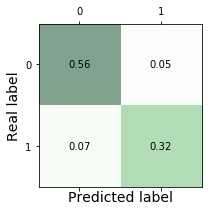

In [26]:
plot_confusion_matrix(y_train, y_train_pred)

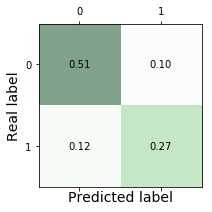

In [27]:
plot_confusion_matrix(y_test, y_test_pred)

The model seems to be overfitted

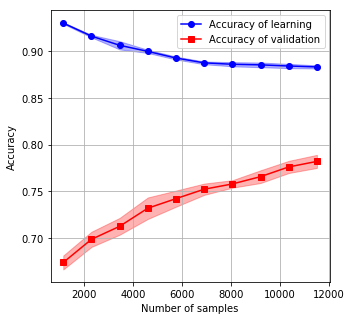

In [167]:
plot_learning_curve(estimator=stem_lr_model, X=X_train_stem_preprocessed, y=y_train)

In [28]:
# lemmatization
lem_pipe = Pipeline([
    ('features', FeatureUnion([
            ('numerical_feats', FrequencyExtractor()),    
            ('text_feats', Pipeline([('preprocessor', TextPreprocessor(stopwords=IRRELEVANT_STOPWORDS, 
                                                                       process='lem')),
                                     ('vectorizer', CountVectorizer(token_pattern=token_pattern, min_df=2))
                                    ]))
            ])),
    ('scaler', MaxAbsScaler())
    ])

In [29]:
X_train_lem_preprocessed = lem_pipe.fit_transform(X_train)
X_test_lem_preprocessed = lem_pipe.transform(X_test)

In [30]:
lem_lr_model = LogisticRegression(penalty='l2', C=1.0)
lem_lr_model.fit(X_train_lem_preprocessed, y_train);

y_train_pred = lem_lr_model.predict(X_train_lem_preprocessed)
y_test_pred = lem_lr_model.predict(X_test_lem_preprocessed)

print('Tarining dataset: accuracy = %.3f' % accuracy_score(y_pred=y_train_pred, y_true=y_train))
print('Test dataset: accuracy = %.3f' % accuracy_score(y_pred=y_test_pred, y_true=y_test))

Tarining dataset: accuracy = 0.881
Test dataset: accuracy = 0.787


In [31]:
y_train_proba = lem_lr_model.predict_proba(X_train_lem_preprocessed)[:, 1]
y_test_proba = lem_lr_model.predict_proba(X_test_lem_preprocessed)[:, 1]
print('Tarining dataset: roc_auc = %.3f' % roc_auc_score(y_score=y_train_proba, y_true=y_train))
print('Test dataset: roc_auc = %.3f' % roc_auc_score(y_score=y_test_proba, y_true=y_test))

Tarining dataset: roc_auc = 0.954
Test dataset: roc_auc = 0.863


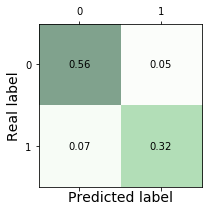

In [32]:
plot_confusion_matrix(y_train, y_train_pred)

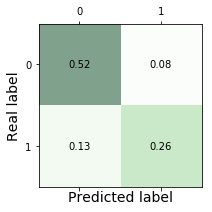

In [33]:
plot_confusion_matrix(y_test, y_test_pred)

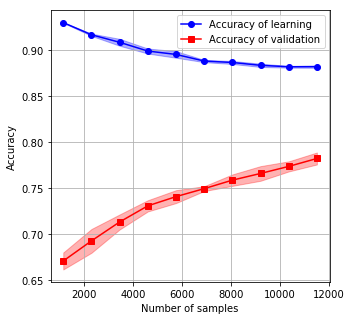

In [174]:
plot_learning_curve(estimator=lem_lr_model, X=X_train_lem_preprocessed, y=y_train)

### RandomForestClassifier

In [34]:
from sklearn.ensemble import RandomForestClassifier

In [35]:
def get_sorted_features(pipe, selector_scores):
    sorted_scores = np.sort(selector_scores)[::-1]
    inds = np.argsort(selector_scores)[::-1]
    word_list = list(pipe.named_steps['features'].transformer_list[1][1].\
                     named_steps['vectorizer'].get_feature_names())
    tag_list = ['NOUN', 'VERB', 'ADJ', 'ADV', 'PRON', 'DET',
                'ADP', 'NUM', 'CONJ', 'PRT', '.', 'X']
    freq_name_list = ['repeatingletters_r', 'uppercase_r', 'firstcapital_r'] + tag_list
    sorted_features = np.array(word_list + freq_name_list)[inds]
    return sorted_features

def print_kbest(pipe, selector_scores, k):
    sorted_scores = np.sort(selector_scores)[::-1]
    sorted_features = get_sorted_features(pipe, selector_scores)
    for i in range(k):
        print('Feature: {0:25s} Score: {1:8.3f}'.format(sorted_features[i], sorted_scores[i]))

In [36]:
stem_rfc_model = RandomForestClassifier(n_estimators=100, max_depth=15, max_features=1000)

stem_rfc_model.fit(X_train_stem_preprocessed, y_train);

y_train_pred = stem_rfc_model.predict(X_train_stem_preprocessed)
y_test_pred = stem_rfc_model.predict(X_test_stem_preprocessed)

print('Tarining dataset: accuracy = %.3f' % accuracy_score(y_pred=y_train_pred, y_true=y_train))
print('Test dataset: accuracy = %.3f' % accuracy_score(y_pred=y_test_pred, y_true=y_test))

Tarining dataset: accuracy = 0.862
Test dataset: accuracy = 0.775


In [37]:
y_train_proba = stem_rfc_model.predict_proba(X_train_stem_preprocessed)[:, 1]
y_test_proba = stem_rfc_model.predict_proba(X_test_stem_preprocessed)[:, 1]
print('Tarining dataset: roc_auc = %.3f' % roc_auc_score(y_score=y_train_proba, y_true=y_train))
print('Test dataset: roc_auc = %.3f' % roc_auc_score(y_score=y_test_proba, y_true=y_test))

Tarining dataset: roc_auc = 0.961
Test dataset: roc_auc = 0.872


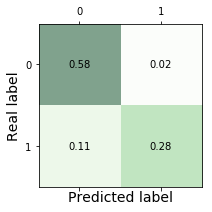

In [38]:
plot_confusion_matrix(y_train, y_train_pred)

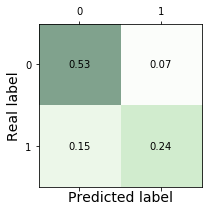

In [39]:
plot_confusion_matrix(y_test, y_test_pred)

In [40]:
print_kbest(stem_pipe, stem_rfc_model.feature_importances_, 10)

Feature: fun                       Score:    0.097
Feature: oprah                     Score:    0.040
Feature: athlet                    Score:    0.034
Feature: abil                      Score:    0.033
Feature: georg                     Score:    0.032
Feature: aardvark                  Score:    0.031
Feature: abandon                   Score:    0.030
Feature: abus                      Score:    0.028
Feature: blame                     Score:    0.027
Feature: absit                     Score:    0.027


In [41]:
lem_rfc_model = RandomForestClassifier(n_estimators=100, max_depth=15, max_features=1000)
lem_rfc_model.fit(X_train_stem_preprocessed, y_train);

y_train_pred = lem_rfc_model.predict(X_train_stem_preprocessed)
y_test_pred = lem_rfc_model.predict(X_test_stem_preprocessed)

print('Tarining dataset: accuracy = %.3f' % accuracy_score(y_pred=y_train_pred, y_true=y_train))
print('Test dataset: accuracy = %.3f' % accuracy_score(y_pred=y_test_pred, y_true=y_test))

Tarining dataset: accuracy = 0.869
Test dataset: accuracy = 0.782


In [42]:
y_train_proba = lem_rfc_model.predict_proba(X_train_stem_preprocessed)[:, 1]
y_test_proba = lem_rfc_model.predict_proba(X_test_stem_preprocessed)[:, 1]
print('Tarining dataset: roc_auc = %.3f' % roc_auc_score(y_score=y_train_proba, y_true=y_train))
print('Test dataset: roc_auc = %.3f' % roc_auc_score(y_score=y_test_proba, y_true=y_test))

Tarining dataset: roc_auc = 0.964
Test dataset: roc_auc = 0.875


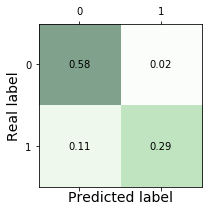

In [43]:
plot_confusion_matrix(y_train, y_train_pred)

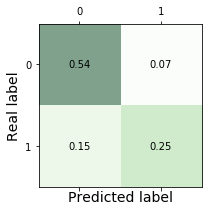

In [44]:
plot_confusion_matrix(y_test, y_test_pred)

In [45]:
print_kbest(lem_pipe, lem_rfc_model.feature_importances_, 10)

Feature: flying                    Score:    0.095
Feature: networking                Score:    0.041
Feature: asleep                    Score:    0.034
Feature: abandon                   Score:    0.032
Feature: aaye                      Score:    0.032
Feature: frensh                    Score:    0.031
Feature: aah                       Score:    0.030
Feature: abundance                 Score:    0.029
Feature: abortion                  Score:    0.027
Feature: bio                       Score:    0.026


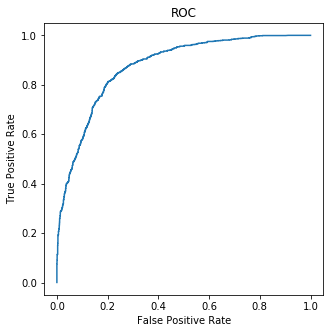

In [46]:
fprs, tprs, thresholds = roc_curve(y_true=y_test, y_score=y_test_proba)

fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(fprs, tprs)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC')
plt.show()

In [47]:
ind = np.argmax(tprs >= 0.75)

print('FPR: %.3f' % fprs[ind])
print('TPR: %.3f' % tprs[ind])
threshold = thresholds[ind]
print('Threshold: %.3f' % threshold)

FPR: 0.167
TPR: 0.750
Threshold: 0.441


In [48]:
y_test_pred_new_threshold = np.where(y_test_proba >= threshold, 1, 0)
print('Test dataset: accuracy = %.3f' % accuracy_score(y_pred=y_test_pred_new_threshold, y_true=y_test))

Test dataset: accuracy = 0.801


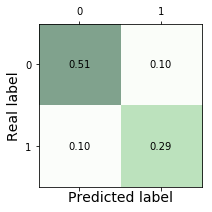

In [49]:
plot_confusion_matrix(y_test, y_test_pred_new_threshold)

## Feature selection

### ANOVA

In [50]:
from sklearn.feature_selection import f_classif, SelectFpr

In [51]:
fpr_stem_selector = SelectFpr(score_func=f_classif, alpha=0.01)
fpr_stem_dtm = fpr_stem_selector.fit_transform(X_train_stem_preprocessed, y_train)
fpr_stem_dtm.shape

(12800, 273)

In [52]:
fpr_lem_selector = SelectFpr(score_func=f_classif, alpha=0.01)
fpr_lem_dtm = fpr_lem_selector.fit_transform(X_train_lem_preprocessed, y_train)
fpr_lem_dtm.shape

(12800, 269)

In [53]:
print_kbest(stem_pipe, fpr_stem_selector.scores_, 10)

Feature: fun                       Score:  621.967
Feature: oprah                     Score:  216.486
Feature: athlet                    Score:  201.574
Feature: blame                     Score:  149.281
Feature: georg                     Score:  143.652
Feature: aardvark                  Score:  116.041
Feature: exact                     Score:   88.250
Feature: whine                     Score:   80.969
Feature: opposit                   Score:   77.936
Feature: end                       Score:   75.726


In [54]:
print_kbest(lem_pipe, fpr_lem_selector.scores_, 10)

Feature: fukin                     Score:  436.185
Feature: oprah                     Score:  216.486
Feature: fury                      Score:  177.097
Feature: blagojevich               Score:  153.608
Feature: generator                 Score:  148.322
Feature: assure                    Score:  147.231
Feature: aah                       Score:  116.041
Feature: ex                        Score:   88.250
Feature: opposite                  Score:   77.936
Feature: enclose                   Score:   75.505


In [55]:
sorted_features = get_sorted_features(stem_pipe, fpr_stem_selector.scores_)
print(sorted_features[:fpr_stem_dtm.shape[1]])

['fun' 'oprah' 'athlet' 'blame' 'georg' 'aardvark' 'exact' 'whine'
 'opposit' 'end' 'energi' 'shortar' 'dom' 'oppos' 'they' 'he' 'sumth'
 'loveabl' 'fell' 'util' 'aay' 'aah' 'cutest' 'wifi' 'honestli'
 'luckystartup' 'shud' 'hamster' 'mario' 'wrt' 'nova' 'yuh' 'rack' 'abt'
 'ikr' 'silver' 'colfax' 'question' 'yhur' 'shown' 'dunkin' 'heaven' 'digg'
 'dare' 'un' 'philippin' 'rainbow' 'hinder' 'impli' 'smoke' 'soup' 'wud'
 'mapl' 'abort' 'chuz' 'favrd' 'blushi' 'nj' 'bush' 'oic' 'xorcist' 'heal'
 'rflect' 'suck' 'youu' 'fam' 'jaman' 'ideal' 'abl' 'ho' 'hahlo' 'ung'
 'funnier' 'marc' 'usb' 'omg' 'yew' 'absurd' 'shrug' 'danni' 'known'
 'canal' 'opportun' 'temp' 'mrh' 'wrong' 'enforc' 'goten' 'selfish'
 'easier' 'planet' 'previous' 'peanut' 'form' 'bamf' 'seattl' 'theori'
 'cut' 'drake' 'wish' 'adjust' 'beamer' 'mic' 'oz' 'hookhand' 'ate' 'fix'
 'cigar' 'oper' 'despit' 'shayla' 'strand' 'graemem' 'sheep' 'threat'
 'cowgurl' 'realz' 'com' 'rusti' 'funer' 'whoop' 'gotta' 'prison' 'stress'
 'di

In [56]:
sorted_features = get_sorted_features(lem_pipe, fpr_lem_selector.scores_)
print(sorted_features[:fpr_lem_dtm.shape[1]])

['fukin' 'oprah' 'fury' 'blagojevich' 'generator' 'assure' 'aah' 'ex'
 'opposite' 'enclose' 'enable' 'dome' 'which' 'shopping' 'opportunity'
 'theres' 'fell' 'hazard' 'love' 'usually' 'aardvark' "'s" 'cut' 'wiff'
 'honolulu' 'shuddup' 'hand' 'marissa' 'wtf' 'racist' 'nova' 'sumthing'
 'yuh' 'summer' 'lucky' 'colfax' 'absurd' 'hola' 'ikno' 'silly' 'dumber'
 'difficult' 'yhu' 'queue' 'showtime' 'darby' 'rain' 'soup' 'impetuosity'
 'un' 'map' 'wut' 'smtg' 'able' 'whip' 'favrd' 'reward' 'chuz' 'ohkay'
 'suck' 'blue' 'bury' 'xmas' 'headache' 'gin' 'heat' 'urgent' 'jake'
 'ideal' 'fall' 'ability' 'hm' 'unfortunately' 'funny' 'nite' 'mario' 'yoo'
 'one' 'hahhaa' 'phelps' 'absorb' 'shud' 'daniel' 'youu' 'knwo' 'heavily'
 'themself' 'canadians' 'telw' 'likee' 'operate' 'encore' 'goten' 'certain'
 'bishop' 'easter' 'own' 'previous' 'peace' 'bamf' 'forth' 'sheep'
 'function' 'hay' 'continuity' 'drain' 'wit' 'addressemail' 'beaker' 'atcq'
 'cigar' 'mic' 'self' 'open' 'prison' 'kill' 'gots' 'meetup

In [57]:
fpr_stem_pipe = Pipeline([
    ('selector', SelectFpr(score_func=f_classif, alpha=0.01)),
    ('clf', LogisticRegression(penalty='l2', C=1.0))
    ])

In [58]:
fpr_stem_pipe.fit(X_train_stem_preprocessed, y_train);

y_train_pred = fpr_stem_pipe.predict(X_train_stem_preprocessed)
y_test_pred = fpr_stem_pipe.predict(X_test_stem_preprocessed)

print('Tarining dataset: accuracy = %.3f' % accuracy_score(y_pred=y_train_pred, y_true=y_train))
print('Test dataset: accuracy = %.3f' % accuracy_score(y_pred=y_test_pred, y_true=y_test))

Tarining dataset: accuracy = 0.733
Test dataset: accuracy = 0.709


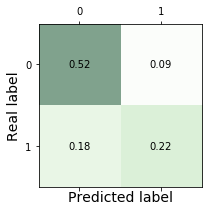

In [59]:
plot_confusion_matrix(y_train, y_train_pred)

In [60]:
fpr_stem_pipe = Pipeline([
    ('selector', SelectFpr(score_func=f_classif, alpha=0.01)),
    ('clf', LogisticRegression(penalty='l2', C=1.0, class_weight={0: 1, 1: 1.25}))
    ])

fpr_stem_pipe.fit(X_train_stem_preprocessed, y_train);

y_train_pred = fpr_stem_pipe.predict(X_train_stem_preprocessed)
y_test_pred = fpr_stem_pipe.predict(X_test_stem_preprocessed)

print('Tarining dataset: accuracy = %.3f' % accuracy_score(y_pred=y_train_pred, y_true=y_train))
print('Test dataset: accuracy = %.3f' % accuracy_score(y_pred=y_test_pred, y_true=y_test))

Tarining dataset: accuracy = 0.738
Test dataset: accuracy = 0.712


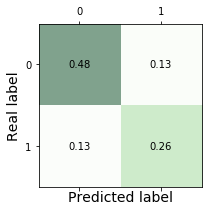

In [61]:
plot_confusion_matrix(y_train, y_train_pred)

### Variance

In [62]:
from sklearn.feature_selection import VarianceThreshold

In [63]:
vr_stem_selector = VarianceThreshold(threshold=10e-4)
vr_stem_dtm = vr_stem_selector.fit_transform(X_train_stem_preprocessed, y_train)
vr_stem_dtm.shape

(12800, 778)

In [64]:
vr_lem_selector = VarianceThreshold(threshold=10e-4)
vr_lem_dtm = vr_lem_selector.fit_transform(X_train_lem_preprocessed, y_train)
vr_lem_dtm.shape

(12800, 745)

In [65]:
print_kbest(stem_pipe, vr_stem_selector.variances_, 10)

Feature: abandon                   Score:    0.033
Feature: abil                      Score:    0.025
Feature: aay                       Score:    0.024
Feature: aardvark                  Score:    0.019
Feature: absit                     Score:    0.018
Feature: abus                      Score:    0.017
Feature: absorb                    Score:    0.015
Feature: dunkin                    Score:    0.014
Feature: abt                       Score:    0.013
Feature: dom                       Score:    0.011


In [66]:
print_kbest(lem_pipe, vr_lem_selector.variances_, 10)

Feature: aaye                      Score:    0.033
Feature: abandon                   Score:    0.025
Feature: aardvark                  Score:    0.024
Feature: aah                       Score:    0.019
Feature: abortion                  Score:    0.018
Feature: abundance                 Score:    0.017
Feature: absolutely                Score:    0.015
Feature: jacket                    Score:    0.014
Feature: absurd                    Score:    0.013
Feature: dumber                    Score:    0.013


In [67]:
sorted_features = get_sorted_features(stem_pipe, vr_stem_selector.variances_)
print(sorted_features[:vr_stem_dtm.shape[1]][:200])

['abandon' 'abil' 'aay' 'aardvark' 'absit' 'abus' 'absorb' 'dunkin' 'abt'
 'dom' 'jacob' 'dose' 'abund' 'athlet' 'adob' 'blame' 'wonder' 'dine' 'he'
 'whine' 'loop' 'fun' 'gotta' 'kids' 'flashlight' 'mankind' 'arsclan'
 'babay' 'induc' 'ideal' 'toyboy' 'amberto' 'shud' 'abort' 'faith'
 'niggaitu' 'ceo' 'hey' 'engag' 'wouldnt' 'amaz' 'energi' 'souljaboy'
 'mario' 'awz' 'thre' 'abl' 'krista' 'analyz' 'oppos' 'naked' 'musician'
 'lotto' 'sent' 'robot' 'umbrella' 'nova' 'ani' 'aah' 'nerv' 'util' 'mapl'
 'heal' 'ive' 'air' 'mind' 'crisi' 'southern' 'ohio' 'shortar' 'absolut'
 'attent' 'stoopid' 'lit' 'threat' 'airplan' 'theori' 'valu' 'nah' 'yhu'
 'dare' 'down' 'exact' 'hahlo' 'project' 'cutest' 'schedul' 'bull' 'evolv'
 'commut' 'coweta' 'eminem' 'aint' 'uhh' 'girl' 'recov' 'honestli' 'soup'
 'els' 'terrifi' 'capitalist' 'holla' 'romo' 'pastor' 'kingston' 'persist'
 'eagl' 'lawn' 'workhors' 'baltimor' 'stripe' 'holli' 'fla' 'belief'
 'hotdog' 'throughout' 'opposit' 'tryin' 'weekend' 'altho

In [68]:
sorted_features = get_sorted_features(lem_pipe, vr_lem_selector.variances_)
print(sorted_features[:vr_lem_dtm.shape[1]][:200])

['aaye' 'abandon' 'aardvark' 'aah' 'abortion' 'abundance' 'absolutely'
 'jacket' 'absurd' 'dumber' 'dome' 'double' 'gots' 'abt' 'mance' 'womens'
 'kill' 'blagojevich' 'din' 'admit' 'looking' 'hazard' 'flash' 'arrive'
 'indirectly' 'b*tch' 'which' 'ideal' 'amberto' 'shuddup' 'able' 'niggas'
 'faith' 'separate' 'center' 'hes' 'encourage' 'amazing' 'wp' 'enclose'
 'krockxp' 'knife' 'marissa' 'thousand' 'ability' 'toyboy' 'amuses'
 'souljaboy' 'opportunity' 'nakedness' 'musical' 'thread' 'fury' 'lotta'
 'robin' 'umbrella' 'animal' 'nova' "'s" 'usually' 'terrible' 'itunes'
 'headache' 'nerdy' 'map' 'assure' 'air' 'milliseconds' 'ballfuck' 'crook'
 'summer' 'sp' 'communist' 'thesoxroxmaster' 'ohh' 'aww' 'absitence'
 'attitude' 'storm' 'fukin' 'lisa' 'shopping' 'airport' 'yew' 'nah'
 'vagina' 'darby' 'load' 'down' 'ex' 'hahhaa' 'sched' 'professional'
 'scene' 'bullshit' 'cut' 'cowboy' 'evil' 'aint' 'stone' 'uh' 'theres'
 'honolulu' 'ecoterrorists' "else's" 'capacity' 'embrace' 'past' 'soup'
 

In [69]:
vr_stem_pipe = Pipeline([
    ('selector', VarianceThreshold(threshold=10e-4)),
    ('clf', LogisticRegression(penalty='l2', C=1.0, class_weight={0: 1, 1: 1.25}))
    ])

vr_stem_pipe.fit(X_train_stem_preprocessed, y_train);

y_train_pred = vr_stem_pipe.predict(X_train_stem_preprocessed)
y_test_pred = vr_stem_pipe.predict(X_test_stem_preprocessed)

print('Tarining dataset: accuracy = %.3f' % accuracy_score(y_pred=y_train_pred, y_true=y_train))
print('Test dataset: accuracy = %.3f' % accuracy_score(y_pred=y_test_pred, y_true=y_test))

Tarining dataset: accuracy = 0.749
Test dataset: accuracy = 0.712


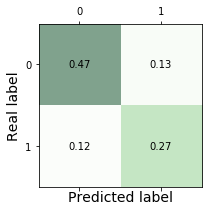

In [70]:
plot_confusion_matrix(y_train, y_train_pred)

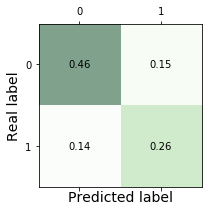

In [71]:
plot_confusion_matrix(y_test, y_test_pred)

## Hyperparameter Tuning

In [72]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import Normalizer

from scipy.stats.distributions import uniform, randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from scipy.spatial.distance import cosine
from pprint import pprint
from sklearn.base import clone

### Number of features

#### Feature selection - CountVectorizer

In [73]:
def count_features(pipe_trans, param_range, param_name, process):
    pipe = clone(pipe_trans)
    no_features = []
    for param in param_range:
        pipe.set_params(**{'preprocessor__process': process, param_name: param})
        dtm = pipe.fit_transform(X_train)
        no_features.append(dtm.shape[1])
    return no_features

def plot_no_features(pipe_trans, param_range, param_name, process):    
    no_features = count_features(pipe_trans, param_range, param_name, process)
    
    fig, ax = plt.subplots(figsize=(5, 5))    
    ax.plot(param_range, no_features, '--o')
    ax.set_xlabel(param_name)
    ax.set_ylabel('Number of features')
    ax.set_title('Process = ' + process)
    ax.grid()
    plt.show()    

In [74]:
tf_pipe = Pipeline([('preprocessor', TextPreprocessor()),
                    ('vectorizer', CountVectorizer(token_pattern=token_pattern))
                   ])

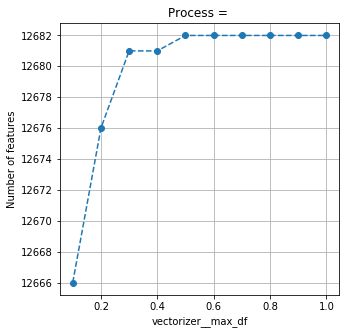

In [257]:
max_df_range = np.arange(0.1, 1.1, 0.1)
process = ''
param_name = 'vectorizer__max_df'
plot_no_features(tf_pipe, max_df_range, param_name, process)

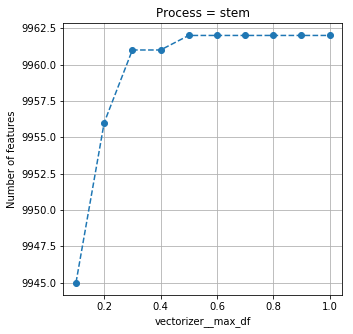

In [260]:
max_df_range = np.arange(0.1, 1.1, 0.1)
process = 'stem'
param_name = 'vectorizer__max_df'
plot_no_features(tf_pipe, max_df_range, param_name, process)

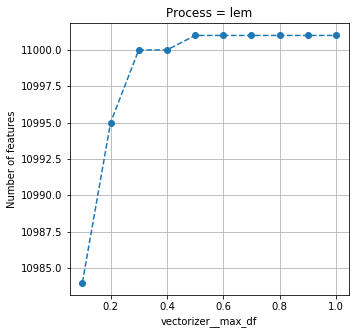

In [261]:
max_df_range = np.arange(0.1, 1.1, 0.1)
process = 'lem'
param_name = 'vectorizer__max_df'
plot_no_features(tf_pipe, max_df_range, param_name, process)

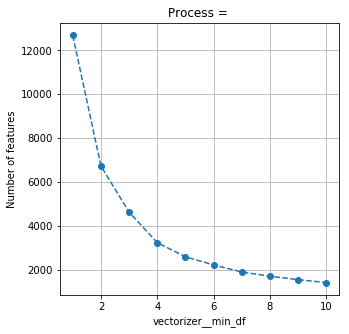

In [263]:
min_df_range = np.arange(1, 11, 1)
process = ''
param_name = 'vectorizer__min_df'
plot_no_features(tf_pipe, min_df_range, param_name, process)

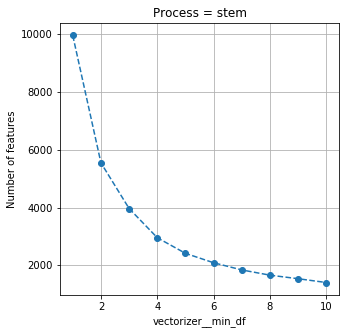

In [264]:
min_df_range = np.arange(1, 11, 1)
process = 'stem'
param_name = 'vectorizer__min_df'
plot_no_features(tf_pipe, min_df_range, param_name, process)

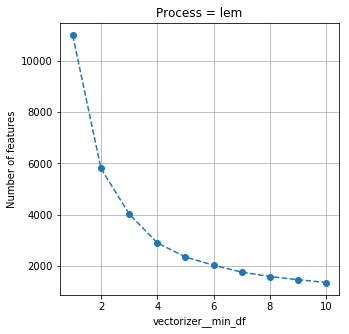

In [265]:
min_df_range = np.arange(1, 11, 1)
process = 'lem'
param_name = 'vectorizer__min_df'
plot_no_features(tf_pipe, min_df_range, param_name, process)

In [75]:
ngram_range = [(1, 1), (1, 2), (2, 2), (1, 3), (1, 4)]
process = ''
param_name = 'vectorizer__ngram_range'
count_features(tf_pipe, ngram_range, param_name, process)

[12680, 82635, 69955, 189991, 298005]

In [76]:
ngram_range = [(1, 1), (1, 2), (2, 2), (1, 3), (1, 4)]
process = 'stem'
param_name = 'vectorizer__ngram_range'
count_features(tf_pipe, ngram_range, param_name, process)

[9962, 76060, 66098, 182406, 290255]

In [77]:
ngram_range = [(1, 1), (1, 2), (2, 2), (1, 3), (1, 4)]
process = 'lem'
param_name = 'vectorizer__ngram_range'
count_features(tf_pipe, ngram_range, param_name, process)

[10999, 77772, 66773, 184312, 292197]

#### Feature extraction - SVD

In [276]:
lsi_pipe= Pipeline([('preprocessor', TextPreprocessor()),
                     ('vectorizer', TfidfVectorizer(token_pattern=token_pattern, norm='l2')),
                     ('svd', TruncatedSVD())
                    ])

In [277]:
component_range = np.arange(100, 2000, 100)
explained_variance = []
for n in component_range:
    lsi_pipe.set_params(**{'svd__n_components': n})
    dtm = lsi_pipe.fit_transform(X_train)
    variance = lsi_pipe.named_steps['svd'].explained_variance_ratio_.sum()
    explained_variance.append(variance)

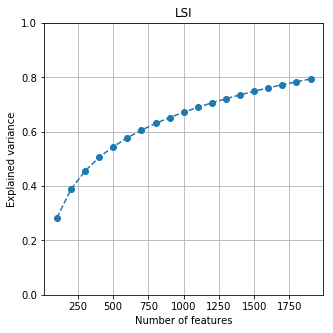

In [278]:
fig, ax = plt.subplots(figsize=(5, 5))    
ax.plot(component_range, explained_variance, '--o')
ax.set_xlabel('Number of features')
ax.set_ylabel('Explained variance')
ax.set_title('LSI')
ax.set_ylim(0, 1)
ax.grid()
plt.show()

In [279]:
lsi_pipe.set_params(**{'svd__n_components': 2})
svd_dtm = lsi_pipe.fit_transform(X_train)
print('Explained variance = %.3f' % lsi_pipe.named_steps['svd'].explained_variance_ratio_.sum())

Explained variance = 0.017


/home/kodolamacz/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
  from ipykernel import kernelapp as app
/home/kodolamacz/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
  app.launch_new_instance()


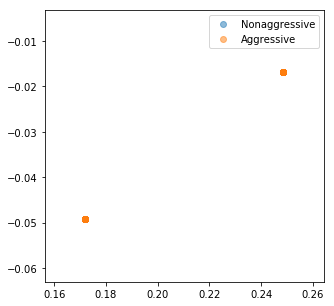

In [280]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(svd_dtm[y_train == 0, 0], svd_dtm[y_train == 0, 1], label='Nonaggressive', alpha=0.5)
ax.scatter(svd_dtm[y_train == 1, 0], svd_dtm[y_train == 1, 1], label='Aggressive', alpha=0.5)
plt.legend()
plt.show()

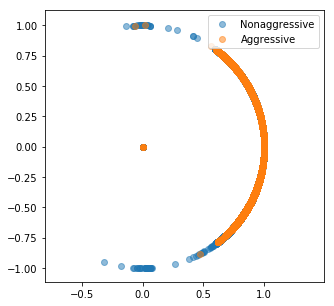

In [80]:
svd_dtm_normalized = Normalizer().fit_transform(svd_dtm)

fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(svd_dtm_normalized[y_train == 0, 0], svd_dtm_normalized[y_train == 0, 1], 
           label='Nonaggressive', alpha=0.5)
ax.scatter(svd_dtm_normalized[y_train == 1, 0], svd_dtm_normalized[y_train == 1, 1], 
           label='Aggressive', alpha=0.5)
plt.axis('equal')
plt.legend()
plt.show()

In [291]:
lsi_pipe = Pipeline([('preprocessor', TextPreprocessor()),
                     ('vectorizer', TfidfVectorizer(token_pattern=token_pattern, norm='l2',
                                                    ngram_range=(1, 2), min_df=2)),
                     ('svd', TruncatedSVD())
                    ])

In [292]:
component_range = np.arange(100, 2000, 100)
explained_variance = []
for n in component_range:
    lsi_pipe.set_params(**{'svd__n_components': n})
    dtm = lsi_pipe.fit_transform(X_train)
    variance = lsi_pipe.named_steps['svd'].explained_variance_ratio_.sum()
    explained_variance.append(variance)

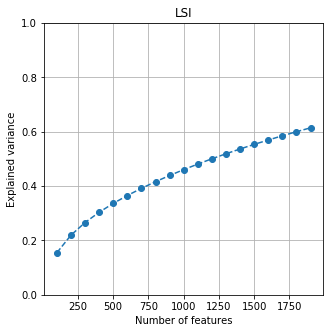

In [293]:
fig, ax = plt.subplots(figsize=(5, 5))    
ax.plot(component_range, explained_variance, '--o')
ax.set_xlabel('Number of features')
ax.set_ylabel('Explained variance')
ax.set_title('LSI')
ax.set_ylim(0, 1)
ax.grid()
plt.show()

### Transformers

#### CountVectorizer: Term Frequency

In [78]:
tf_pipe = Pipeline([
    ('features', FeatureUnion([
            ('freq_feats', FrequencyExtractor()),    
            ('text_feats', Pipeline([('preprocessor', TextPreprocessor(stopwords=IRRELEVANT_STOPWORDS, 
                                                                       process='stem')),
                                     ('vectorizer', CountVectorizer(token_pattern=token_pattern, min_df=2,
                                                                    ngram_range=(1, 2)))
                                    ]))
            ])),
    ('scaler', MaxAbsScaler())
    ])

preprocessor_path = 'transformer__features__text_feats__preprocessor'
vectorizer_path = 'transformer__features__text_feats__vectorizer'
tf_param_dist = {preprocessor_path + '__stopwords': [IRRELEVANT_STOPWORDS, STOPWORDS, []],
                 preprocessor_path + '__process': ['lem', 'stem', ''],
                 vectorizer_path + '__ngram_range': [(1, 1), (1, 2), (2, 2)],
                 vectorizer_path + '__min_df': randint(1, 6)
                 }

In [79]:
tf_dtm_train = tf_pipe.fit_transform(X_train)
tf_dtm_test = tf_pipe.transform(X_test)

#### TfidfVectorizer: Term Frequency - Inverse Document Frequency

In [80]:
tfidf_pipe = Pipeline([
    ('features', FeatureUnion([
            ('freq_feats', FrequencyExtractor()),    
            ('text_feats', Pipeline([('preprocessor', TextPreprocessor(stopwords=IRRELEVANT_STOPWORDS, 
                                                                       process='stem')),
                                     ('vectorizer', TfidfVectorizer(token_pattern=token_pattern, min_df=2,
                                                                    ngram_range=(1, 2), norm='l2'))
                                    ]))
            ]))
    ])

tfidf_param_dist = {preprocessor_path + '__stopwords': [IRRELEVANT_STOPWORDS, STOPWORDS, []],
                    preprocessor_path + '__process': ['lem', 'stem', ''],
                    vectorizer_path + '__ngram_range': [(1, 1), (1, 2), (2, 2)],
                    vectorizer_path + '__min_df': randint(1, 6)
                    }

In [81]:
tfidf_dtm_train = tfidf_pipe.fit_transform(X_train)
tfidf_dtm_test = tfidf_pipe.transform(X_test)

#### SVD: Singular Value Decomposition (Latent Semantic Indexing)

In [82]:
lsi_pipe = Pipeline([
    ('features', FeatureUnion([
            ('freq_feats', FrequencyExtractor()),    
            ('text_feats', Pipeline([('preprocessor', TextPreprocessor(stopwords=IRRELEVANT_STOPWORDS, 
                                                                       process='stem')),
                                     ('vectorizer', TfidfVectorizer(token_pattern=token_pattern, min_df=2,
                                                                    ngram_range=(1, 2), norm='l2')),
                                     ('svd', TruncatedSVD(n_components=2000)),
                                     ('normalizer', Normalizer())
                                    ]))
            ]))
    ])

svd_path = 'transformer__features__text_feats__svd'
lsi_param_dist = {preprocessor_path + '__stopwords': [IRRELEVANT_STOPWORDS, STOPWORDS, []],
                  preprocessor_path + '__process': ['lem', 'stem', ''],
                  vectorizer_path + '__ngram_range': [(1, 1), (1, 2), (2, 2)],
                  vectorizer_path + '__min_df': randint(1, 6),
                  svd_path + '__n_components': randint(100, 2000)
                  }

In [83]:
lsi_dtm_train = lsi_pipe.fit_transform(X_train)
lsi_dtm_test = lsi_pipe.transform(X_test)

In [84]:
lsi_pipe.named_steps['features'].transformer_list[1][1].named_steps['svd'].explained_variance_ratio_.sum()

0.64564843277100437

#### LatentDirichletAllocation

In [85]:
lda_pipe = Pipeline([
    ('features', FeatureUnion([
            ('freq_feats', FrequencyExtractor()),    
            ('text_feats', Pipeline([('preprocessor', TextPreprocessor(stopwords=IRRELEVANT_STOPWORDS, 
                                                                       process='stem')),
                                     ('vectorizer', TfidfVectorizer(token_pattern=token_pattern, min_df=2,
                                                                    ngram_range=(1, 2), norm='l2')),
                                     ('lda', LatentDirichletAllocation(n_topics=25, learning_method='online', 
                                                                       doc_topic_prior=0.04,
                                                                       topic_word_prior=0.04))
                                    ]))
            ]))
    ])

lda_path = 'transformer__features__text_feats__lda'
lda_param_dist = {preprocessor_path + '__stopwords': [IRRELEVANT_STOPWORDS, STOPWORDS, []],
                  preprocessor_path + '__process': ['lem', 'stem', ''],
                  vectorizer_path + '__ngram_range': [(1, 1), (1, 2), (2, 2)],
                  vectorizer_path + '__min_df': randint(1, 6),
                  lda_path + '__n_topics': randint(10, 50),
#                   lda_path + '__n_components': randint(10, 50),
                  lda_path + '__doc_topic_prior': uniform(0.01, 3 - 0.01),
                  lda_path + '__topic_word_prior': uniform(0.01, 3 - 0.01)
                  }

In [86]:
lda_dtm_train = lda_pipe.fit_transform(X_train)
lda_dtm_test = lda_pipe.transform(X_test)

In [87]:
X_train_dict = {'tf': tf_dtm_train,
                'tfidf': tfidf_dtm_train,
                'lsi': lsi_dtm_train,
                'lda': lda_dtm_train,
                'original': X_train
                }

X_test_dict = {'tf': tf_dtm_test,
               'tfidf': tfidf_dtm_test,
               'lsi': lsi_dtm_test,
               'lda': lda_dtm_test,
               'original': X_test
               }

In [88]:
transformers = [('tf', tf_pipe),
                ('tfidf', tfidf_pipe),
                ('lsi', lsi_pipe),
                ('lda', lda_pipe)                
               ]

transformers_param_dist = {'tf': tf_param_dist,
                           'tfidf': tfidf_param_dist,
                           'lsi': lsi_param_dist,
                           'lda': lda_param_dist
                          }

### Estimators

In [89]:
estimators = {'lr': LogisticRegression(),
              'lin_svm': SVC(kernel='linear', probability=True),
              'rbf_svm': SVC(kernel='rbf', probability=True),
              'dt': DecisionTreeClassifier(),
              'knn': KNeighborsClassifier(),
              'nb': GaussianNB(),
              'lda': LinearDiscriminantAnalysis(),
              'qda': QuadraticDiscriminantAnalysis(),
             }

estimators_param_dist = {'lr': {'clf__penalty': ['l1', 'l2'],
                                'clf__C': uniform(0., 4.)},
                         'lin_svm': {'clf__C': uniform(0., 4.)},
                         'rbf_svm': {'clf__C': uniform(0., 4.),
                                     'clf__gamma': uniform(0.1, 3 - 0.1)},
                         'dt': {'clf__max_depth': randint(5, 15),
                                'clf__min_samples_leaf': randint(2, 40)},
                         'knn': {'clf__n_neighbors': randint(4, 15),
                                 'clf__metric': ['minkowski', cosine]},
                         'nb': {}, 
                         'lda': {},
                         'qda': {},
                        }

### Classification

In [90]:
def search_best_clfs(clf_name, X_train_dict, X_test_dict, transformation=False, n_iter=3):
    best_clfs = {}
    scores = pd.DataFrame(columns=[clf_name + '_train', clf_name + '_test'])

    for trans_name, trans_pipe in transformers:
        print(trans_name)
        if transformation:
            pipe = Pipeline([('transformer', clone(trans_pipe)),
                             ('clf', clone(estimators[clf_name]))])

            param_dist = transformers_param_dist[trans_name].copy()
            param_dist.update(estimators_param_dist[clf_name].items())
            
            X_train = X_train_dict['original']
            X_test = X_test_dict['original']
        else:
            pipe = Pipeline([('clf', clone(estimators[clf_name]))])
            param_dist = estimators_param_dist[clf_name]
            
            X_train = X_train_dict[trans_name]
            X_test = X_test_dict[trans_name]

        rs = RandomizedSearchCV(estimator=pipe, param_distributions=param_dist, 
                                n_iter=n_iter, n_jobs=-1, refit=True,
                                scoring='accuracy',
                                cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=10))

        rs.fit(X_train, y_train)

        best_clfs.update({trans_name: rs.best_estimator_})

        train_score = rs.score(X_train, y_train)
        test_score = rs.score(X_test, y_test)
        scores.loc[trans_name] = [train_score, test_score]
        
    return best_clfs, scores

In [91]:
import pickle
import os

In [92]:
def save_model(model, file_name):
    models_path = './Models'
    if not os.path.exists(models_path):
        os.makedirs(models_path)
    
    with open(os.path.join(models_path, file_name), 'wb') as file:
        pickle.dump(model, file, protocol=4)

In [93]:
def save_kbest(kbest_array, file_name):
    models_path = './kBest'
    if not os.path.exists(models_path):
        os.makedirs(models_path)

    np.savetxt(os.path.join(models_path, file_name), kbest_array, fmt='%s')

#### Logistic Regression

In [338]:
clf_name = 'lr'
best_lrs, lr_scores = search_best_clfs(clf_name, X_train_dict, X_test_dict)

In [339]:
lr_scores

,lr_train,lr_test
tf,0.989297,0.890938
tfidf,0.944531,0.833125
lsi,0.870781,0.780000
lda,0.685781,0.664375


In [340]:
for name, model in best_lrs.items():
    file_name = name + '_logisticregression.p'
    save_model(model, file_name)

In [347]:
pprint(best_lrs['tf'].named_steps['clf'].get_params())

{'C': 3.8380999372657909,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'max_iter': 100,
 'multi_class': 'ovr',
 'n_jobs': 1,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}


In [342]:
pprint(best_lrs['tfidf'].named_steps['clf'].get_params())

{'C': 1.9940595970744734,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'max_iter': 100,
 'multi_class': 'ovr',
 'n_jobs': 1,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}


In [343]:
pprint(best_lrs['lsi'].named_steps['clf'].get_params())

{'C': 3.884817013579597,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'max_iter': 100,
 'multi_class': 'ovr',
 'n_jobs': 1,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}


In [345]:
pprint(best_lrs['lda'].named_steps['clf'].get_params())

{'C': 2.8310905729662865,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'max_iter': 100,
 'multi_class': 'ovr',
 'n_jobs': 1,
 'penalty': 'l1',
 'random_state': None,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}


We can look at the learning and validation curve to check overfitting/underfitting

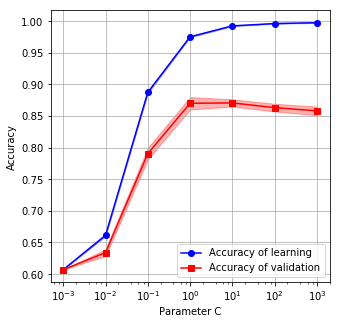

In [348]:
trans_name = 'tf'
plot_validation_curve(estimator=clone(best_lrs[trans_name]), X=X_train_dict[trans_name], y=y_train, 
                      param_name='clf__C', param_range=np.logspace(-3, 3, 7), x_scale='log')

In [388]:
trans_name = 'tf'
lr_pipe = clone(best_lrs[trans_name])
lr_pipe.set_params(**{'clf__C': 1.})

lr_pipe.fit(X_train_dict[trans_name], y_train);

y_train_pred = lr_pipe.predict(X_train_dict[trans_name])
y_test_pred = lr_pipe.predict(X_test_dict[trans_name])
print('Tarining dataset: accuracy = %.3f' % accuracy_score(y_pred=y_train_pred, y_true=y_train))
print('Test dataset: accuracy = %.3f' % accuracy_score(y_pred=y_test_pred, y_true=y_test))

Tarining dataset: accuracy = 0.974
Test dataset: accuracy = 0.872


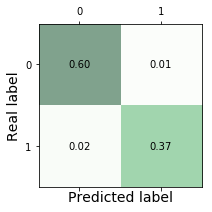

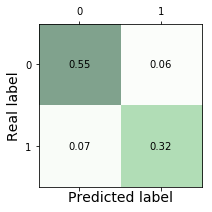

In [389]:
plot_confusion_matrix(y_train, y_train_pred)
plot_confusion_matrix(y_test, y_test_pred)

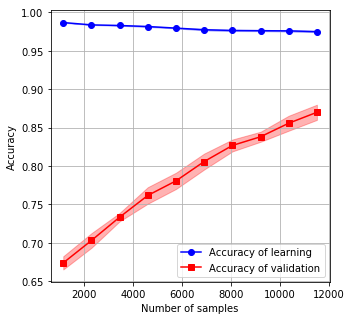

In [390]:
plot_learning_curve(estimator=clone(lr_pipe), X=X_train_dict[trans_name], y=y_train)

In [94]:
from sklearn.model_selection import cross_val_score
import scipy

In [95]:
# X_extended = scipy.sparse.vstack([X_train_dict[trans_name], X_test_dict[trans_name]])
# X_extended.shape

In [96]:
X_extended = np.r_[X_train, X_test]
y_extended = np.r_[y_train, y_test]
print(X_extended.shape, y_extended.shape)

(16000,) (16000,)


In [472]:
lr_pipe_extended = Pipeline([('transformers', clone(tf_pipe)),
                             ('clf', clone(lr_pipe.named_steps['clf']))])

extended_scores = cross_val_score(lr_pipe_extended, X_extended, y_extended, scoring='accuracy', 
                                  cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=10))
print(np.round(extended_scores, 3))
print('Validation: accuracy = %.3f' % extended_scores.mean())

[ 0.867  0.866  0.869  0.864  0.872]
Validation: accuracy = 0.867


In [490]:
lr_pipe_extended.fit(X_extended, y_extended)
y_extended_pred = lr_pipe_extended.predict(X_extended)
print('Tarining dataset: accuracy = %.3f' % accuracy_score(y_pred=y_extended_pred, y_true=y_extended))

Tarining dataset: accuracy = 0.979


In [491]:
file_name = 'logisticregression.p'
model = lr_pipe_extended
save_model(model, file_name)

In [494]:
importance = np.abs(lr_pipe_extended.named_steps['clf'].coef_[0, :])
print_kbest(lr_pipe_extended.named_steps['transformers'], importance, 10)

Feature: fuck annoy                Score:    6.603
Feature: bitch cuz                 Score:    4.289
Feature: gay card                  Score:    4.032
Feature: hate are                  Score:    3.495
Feature: emo haha                  Score:    3.485
Feature: ass bad                   Score:    3.356
Feature: onequestionmark better    Score:    3.244
Feature: suck cock                 Score:    3.133
Feature: damn australian           Score:    3.021
Feature: loser market              Score:    2.782


In [496]:
sorted_features = get_sorted_features(lr_pipe_extended.named_steps['transformers'], importance)
print(sorted_features[:100])

['fuck annoy' 'bitch cuz' 'gay card' 'hate are' 'emo haha' 'ass bad'
 'onequestionmark better' 'suck cock' 'damn australian' 'loser market'
 'fat burn' 'uh manyexclamationmark' 'whore oneexclamationmark'
 'damn reply' 'cock my' 'ever felt' 'whuut' 'gay run'
 'dick onequestionmark' 'emoticonhappyfac emoticonheart' 'dude ur'
 'nerd know' 'realtor' 'nose onequestionmark' 'small' 'hate procrastin'
 'pig part' 'whose would' 'holdin phone' 'cunt that' 'damn addressurl'
 'hate myzou' 'suck they' 'two peopl' 'fail onedot' 'pussi wanna'
 'danc around' 'slam' 'bitch though' 'what coincid' 'that that'
 'whup emoticonhappyfac' 'like he' 'favorit music' 'abbey'
 'freak oneexclamationmark' 'hate oneexclamationmark' 'shit get'
 'failur anyway' 'think they' 'good onequestionmark' 'fuck boo' 'do realiz'
 "damn i'm" 'haha emoticonheart' 'admit it' 'bitch still' 'love em'
 'gay rotfl' 'of hi' 'damn bama' 'lost bet' 'that ladi' 'hate free'
 'know onequestionmark' 'smallest' 'retro' 'wow ohkay' 'awesom rig

In [497]:
k = 1000
file_name = 'logisticregression' + str(k) + '.csv'
kbest_array = sorted_features[:k]
save_kbest(kbest_array, file_name)

In [414]:
# best_lrs['lsi'].named_steps['transformers'].named_steps['svd'].explained_variance_ratio_.sum()

In [415]:
# best_lrs['lsi'].named_steps['transformers'].named_steps['svd'].get_params()

#### Linear SVM

In [465]:
clf_name = 'lin_svm'
best_lin_svms, lin_svm_scores = search_best_clfs(clf_name, X_train_dict, X_test_dict, n_iter=3)

KeyboardInterrupt: 

In [ ]:
lin_svm_scores

In [ ]:
for name, model in best_lin_svms.items():
    file_name = name + '_linearsvm.p'
    save_model(model, file_name)

#### SVM with kernel RBF

In [ ]:
clf_name = 'rbf_svm'
best_rbf_svms, rbf_svm_scores = search_best_clfs(clf_name, X_train_dict, X_test_dict, n_iter=4)

tf


In [118]:
rbf_svm_scores

,svm_rbf_train,svm_rbf_test
tf,0.994922,0.930937
tfidf,0.995703,0.932187
lsi,0.994219,0.925937
lda,0.783359,0.714688


In [340]:
for name, model in best_rbf_svms.items():
    file_name = name + '_rbfsvm.p'
    save_model(model, file_name)

In [347]:
pprint(best_rbf_svms['tf'].named_steps['clf'].get_params())

{'C': 3.8380999372657909,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'max_iter': 100,
 'multi_class': 'ovr',
 'n_jobs': 1,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}


In [342]:
pprint(best_rbf_svms['tfidf'].named_steps['clf'].get_params())

{'C': 1.9940595970744734,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'max_iter': 100,
 'multi_class': 'ovr',
 'n_jobs': 1,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}


In [343]:
pprint(best_rbf_svms['lsi'].named_steps['clf'].get_params())

{'C': 3.884817013579597,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'max_iter': 100,
 'multi_class': 'ovr',
 'n_jobs': 1,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}


In [345]:
pprint(best_rbf_svms['lda'].named_steps['clf'].get_params())

{'C': 2.8310905729662865,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'max_iter': 100,
 'multi_class': 'ovr',
 'n_jobs': 1,
 'penalty': 'l1',
 'random_state': None,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}


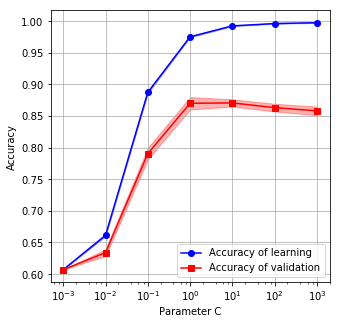

In [348]:
trans_name = 'tf'
plot_validation_curve(estimator=clone(best_rbf_svms[trans_name]), X=X_train_dict[trans_name], y=y_train, 
                      param_name='clf__C', param_range=np.logspace(-3, 3, 7), x_scale='log')

In [388]:
trans_name = 'tf'
rbf_svm_pipe = clone(best_rbf_svms[trans_name])
rbf_svm_pipe.set_params(**{'clf__C': 1.})

rbf_svm_pipe.fit(X_train_dict[trans_name], y_train);

y_train_pred = rbf_svm_pipe.predict(X_train_dict[trans_name])
y_test_pred = rbf_svm_pipe.predict(X_test_dict[trans_name])
print('Tarining dataset: accuracy = %.3f' % accuracy_score(y_pred=y_train_pred, y_true=y_train))
print('Test dataset: accuracy = %.3f' % accuracy_score(y_pred=y_test_pred, y_true=y_test))

Tarining dataset: accuracy = 0.974
Test dataset: accuracy = 0.872


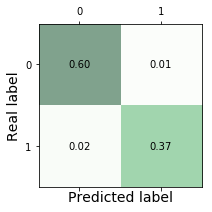

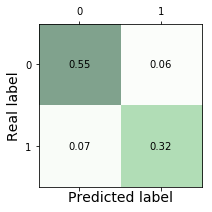

In [389]:
plot_confusion_matrix(y_train, y_train_pred)
plot_confusion_matrix(y_test, y_test_pred)

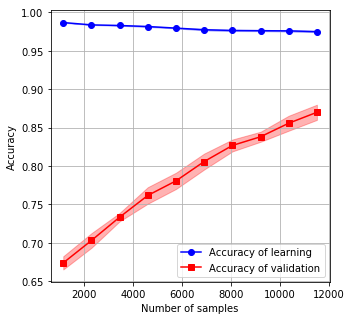

In [390]:
plot_learning_curve(estimator=clone(rbf_svm_pipe), X=X_train_dict[trans_name], y=y_train)

In [96]:
X_extended = np.r_[X_train, X_test]
y_extended = np.r_[y_train, y_test]
print(X_extended.shape, y_extended.shape)

(16000,) (16000,)


In [472]:
rbf_svm_pipe_extended = Pipeline([('transformers', clone(tf_pipe)),
                                  ('clf', clone(rbf_svm_pipe.named_steps['clf']))])

extended_scores = cross_val_score(lr_pipe_extended, X_extended, y_extended, scoring='accuracy', 
                                  cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=10))
print(np.round(extended_scores, 3))
print('Validation: accuracy = %.3f' % extended_scores.mean())

[ 0.867  0.866  0.869  0.864  0.872]
Validation: accuracy = 0.867


In [490]:
rbf_svm_pipe_extended.fit(X_extended, y_extended)
y_extended_pred = rbf_svm_pipe_extended.predict(X_extended)
print('Tarining dataset: accuracy = %.3f' % accuracy_score(y_pred=y_extended_pred, y_true=y_extended))

Tarining dataset: accuracy = 0.979


In [491]:
file_name = 'rbfsvm.p'
model = rbf_svm_pipe_extended
save_model(model, file_name)

In [494]:
importance = np.abs(rbf_svm_pipe_extended.named_steps['clf'].coef_[0, :])
print_kbest(rbf_svm_pipe_extended.named_steps['transformers'], importance, 10)

Feature: fuck annoy                Score:    6.603
Feature: bitch cuz                 Score:    4.289
Feature: gay card                  Score:    4.032
Feature: hate are                  Score:    3.495
Feature: emo haha                  Score:    3.485
Feature: ass bad                   Score:    3.356
Feature: onequestionmark better    Score:    3.244
Feature: suck cock                 Score:    3.133
Feature: damn australian           Score:    3.021
Feature: loser market              Score:    2.782


In [496]:
sorted_features = get_sorted_features(rbf_svm_pipe_extended.named_steps['transformers'], importance)
print(sorted_features[:100])

['fuck annoy' 'bitch cuz' 'gay card' 'hate are' 'emo haha' 'ass bad'
 'onequestionmark better' 'suck cock' 'damn australian' 'loser market'
 'fat burn' 'uh manyexclamationmark' 'whore oneexclamationmark'
 'damn reply' 'cock my' 'ever felt' 'whuut' 'gay run'
 'dick onequestionmark' 'emoticonhappyfac emoticonheart' 'dude ur'
 'nerd know' 'realtor' 'nose onequestionmark' 'small' 'hate procrastin'
 'pig part' 'whose would' 'holdin phone' 'cunt that' 'damn addressurl'
 'hate myzou' 'suck they' 'two peopl' 'fail onedot' 'pussi wanna'
 'danc around' 'slam' 'bitch though' 'what coincid' 'that that'
 'whup emoticonhappyfac' 'like he' 'favorit music' 'abbey'
 'freak oneexclamationmark' 'hate oneexclamationmark' 'shit get'
 'failur anyway' 'think they' 'good onequestionmark' 'fuck boo' 'do realiz'
 "damn i'm" 'haha emoticonheart' 'admit it' 'bitch still' 'love em'
 'gay rotfl' 'of hi' 'damn bama' 'lost bet' 'that ladi' 'hate free'
 'know onequestionmark' 'smallest' 'retro' 'wow ohkay' 'awesom rig

In [497]:
k = 1000
file_name = 'rbfsvm' + str(k) + '.csv'
kbest_array = sorted_features[:k]
save_kbest(kbest_array, file_name)

#### Decision Tree

In [ ]:
clf_name = 'dt'
best_dts, dt_scores = search_best_clfs(clf_name, X_train_dict, X_test_dict, n_iter=4)

#### K-Nearest Neighbors

In [ ]:
clf_name = 'knn'
best_knns, knn_scores = search_best_clfs(clf_name, X_train_dict, X_test_dict, n_iter=4)

In [ ]:
clf_name = 'nb'
best_nbs, nb_scores = search_best_clfs(clf_name, X_train_dict, X_test_dict, n_iter=4)

In [ ]:
clf_name = 'lda'
best_ldas, lda_scores = search_best_clfs(clf_name, X_train_dict, X_test_dict, n_iter=4)

In [ ]:
clf_name = 'qda'
best_qdas, qda_scores = search_best_clfs(clf_name, X_train_dict, X_test_dict, n_iter=4)